# How did Donald Trump's election win affect the market?

This report will examine the effect of Donald Trump's election win, as well as the effect across the market of Trump administration policies made in the years following his election. In this report, data is utilized to show the statistically significant positive and negative effects of his election and policies. 

## How did the market react around the election?

In order to look at how the market reacted around the time of the election date, we decided to first look at an analysis of the market around that period, as well as look at the reaction of a number of key industries referenced by Trump during his campaign trail.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader as pdr
import seaborn as sns
import datetime as dt
from datetime import datetime
pd.options.mode.chained_assignment = None  # default='warn'
from functools import reduce
import statsmodels.formula.api as smf
np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
# helper functions
def datediff(d1, d2):
    x = datetime.strptime(d1, "%Y-%m-%d")
    y = datetime.strptime(d2, "%Y-%m-%d")
    return (x - y).days
def cumret(r):
    return (1 + r).cumprod() - 1
def totret(r):
    return (r + 1).prod() - 1

In [5]:
# Data Frames

ff = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900')[0]/100
ff['Mkt'] = ff['Mkt-RF'] + ff['RF']
ff['Date'] = ff.index
ff['Date'] = ff['Date'].dt.strftime('%Y-%m-%d')

fi = pdr.get_data_famafrench('49_Industry_Portfolios_daily', start='1900')[0]/100
fi.columns = fi.columns.str.replace(' ' or '  ', '')

df = fi.join(ff[['Mkt']])

df_comp = df.copy()
df_comp['Date'] = df_comp.index
df_comp['Date'] = df_comp['Date'].dt.strftime('%Y-%m-%d')


In [40]:
obama_1_win = '2008-11-04'
obama_2_win = '2012-11-06'
trump_win = '2016-11-09'
corp_tax_cuts = '2017-12-22'
china_goods_tariff = '2018-3-22'
steel_tariff = '2018-3-1'
ACE_rule_implementation = '2019-6-19'

The above cell are all the important dates we analyzed over the project. We picked the dates when we thought the announcment would create the largest reaction. 

In [12]:
def comparison (industry, bef, aft,loc):
    trump = df_comp.loc['2016':'2017']
    trump['dfw'] = trump.apply(lambda x: datediff(x['Date'],trump_win), axis=1)
    trump_dfw = trump.set_index([trump.dfw])
    trump_dfw.rename(columns = {'dfw':'dfw_trump'},inplace=True)
    obama_1 = df_comp.loc['2008':'2009']
    obama_1['dfw'] = obama_1.apply(lambda x: datediff(x['Date'],obama_1_win), axis=1)
    obama_1_dfw = obama_1.set_index([obama_1.dfw])
    obama_1_dfw.rename(columns = {'dfw':'dfw_obama_1'},inplace=True)
    obama_2 = df_comp.loc['2012':'2013']
    obama_2['dfw'] = obama_2.apply(lambda x: datediff(x['Date'],obama_2_win), axis=1)
    obama_2_dfw = obama_2.set_index([obama_2.dfw])
    obama_2_dfw.rename(columns = {'dfw':'dfw_obama_2'},inplace=True)
    dfs = [trump_dfw, obama_1_dfw, obama_2_dfw]
    df_final = reduce(lambda left,right: pd.merge(left,right,on='dfw'), dfs)[[industry + '_y',industry,industry + '_x']].loc[bef:aft]
    df_final.rename(columns = {industry + '_x':'2016 Trump',industry + '_y':'2008 Obama',industry:'2012 Obama'},inplace=True)
    df_final['Cumu Returns 2008'] = df_final[['2008 Obama']].apply(cumret)*100
    df_final['Cumu Returns 2012'] = df_final[['2012 Obama']].apply(cumret)*100
    df_final['Cumu Returns 2016'] = df_final[['2016 Trump']].apply(cumret)*100
    plt.plot(df_final['Cumu Returns 2008'], color = 'lightsteelblue')
    plt.plot(df_final['Cumu Returns 2012'], color = 'blue')
    plt.plot(df_final['Cumu Returns 2016'], color = 'red')
    plt.axvline(0, color = 'black', ls = '--')
    plt.legend(['2008', '2012','2016'], loc = loc)
    plt.title(industry + ' Cumulative Return Of 3 Prior Elections')
    plt.xlabel('Days From Election Win Announcment')
    plt.ylabel('Cumulative Returns (%)')
    plt.show()

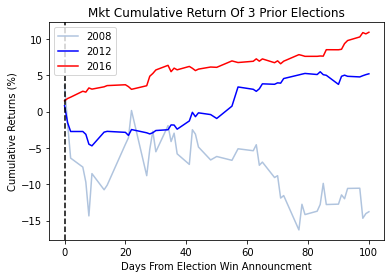

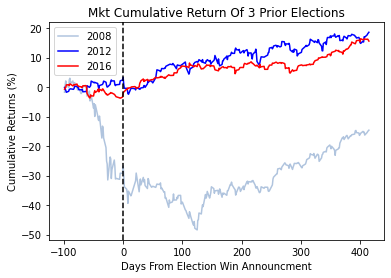

In [13]:
comparison('Mkt',0,100, 'upper left')
comparison('Mkt',-100,500, 'upper left')


Before we start with any analysis surrounding Trump's win. We thought it would be beneficial to take a look at how the general market performed before and after the election announcment. We accomplished this by setting the index of 3 databases (of the 3 elections prior) as the data difference from when the election winner was announced. From the graph above, we can see that the stock market after Trump's election increased more than 10% for the 100 days after the winner was announced. It is important to note that Obama was elected in the midst of the 2008 financial crisis, so the data is extremely volatile which must be considered when doing this analysis. 

We also looked at the cumulative return of the market in the 400 or so days after the election in order to see if the trend that we observed in the first graph continued and we can see that the stock market continued to increase.

In [14]:
labels = {'Fin': 'Finance', 'Banks':'Banking', 'Drugs':'Drugs', 'Insur':'Insurance','Hlth': 'Health', 'Gold': 'Gold', 'Coal':'Coal', 'Txtls': 'Textiles', 'Steel': 'Steel', 'Autos':'Autos', 'Aero':'Aero'}
def days_weeks(win_date, industry):
    evt_pm = 20
    est_N = 252
    evt_dt = pd.to_datetime(win_date)
    evt_i = df.index.get_loc((evt_dt))
    est_l = evt_i - evt_pm - est_N
    est_r = evt_i - evt_pm
    evt_l = evt_i - evt_pm
    evt_r = evt_i + evt_pm + 1
    res = smf.ols(formula = industry + ' ~ Mkt', data = df.iloc[est_l:est_r]).fit()
    df['RET_hat'] = res.predict(df.iloc[evt_l:evt_r]) # expected return based on CAPM and actual market returns
    df['AR'] = df[industry] - df['RET_hat'] # abnormal or unexpected return
    df['AR_t'] = df['AR'] / np.sqrt(res.scale) # t-stat on abnormal or unexpected return
    cumu_df = fi[[industry]].iloc[evt_l:evt_r].apply(cumret).join(df['AR_t']).dropna()
    x = cumu_df.index
    y1 = cumu_df[industry] * 100
    y2 = cumu_df['AR_t']
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax2.scatter(x,y2, color = np.where(np.abs(y2) > 1.96, 'blue', 'lightsteelblue'), alpha = 0.3)
    ax1.plot(x,y1, color = 'black')
    ax1.set_ylabel('Cumulative Returns (%)', color = 'black')
    ax2.set_ylabel('t-Statistic for Abnormal Returns', color = 'blue')
    plt.axvline(evt_dt, color = 'black', ls = '--')
    fig.autofmt_xdate()
    ax1.set_title(labels[industry] + ' Industry Analysis')
    plt.show()

The above code allowed us to simultaneously look at the cumulative return over a 40 day period centered on specific dates that we chose along with the t-statistic of abnormal returns based on the prior 252 days of data. This allows us to see if Trump's surprise win affected the market along with if that affect was out of the ordinary shown through a dark blue dot which represents abnormal returns.

This section analyzes the days and weeks before and after the election win. We decided to look at the following industries: banking, finance, insurance, health, gold, coal and the auto industry. We chose to look at such a wide range to gain a better understanding of how the things said on the campaign trail about these industries really affected these industries. 

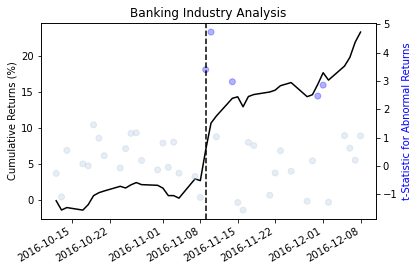

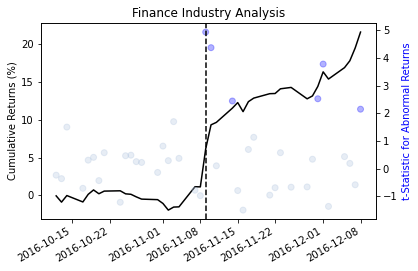

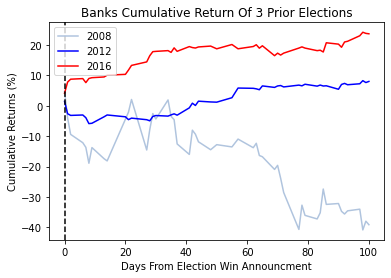

In [10]:
days_weeks(trump_win,'Banks')
days_weeks(trump_win,'Fin')
comparison('Banks',0,100, 'upper left')

In [11]:
corr = str(np.around(fi[['Fin', 'Banks']].loc['2010':'2020'].corr().iloc[1,0]*100,2))
print('Correlation of Finance and Banking Sector from 2010 to 2020: ' + corr +'%')

Correlation of Finance and Banking Sector from 2010 to 2020: 93.04%


It is important to note that the banking and financial sectors are extremly well correlated in the last 10 years with a correlation coefficent of 93%. So for our analysis we are expecting trends within the bank industry to be relatively representative of finance. 


Banks went up significantly the week after his election win. All the points before the election were within the expected range of 2 t values, whereas the returns following the election announcment are well above what we would expect a normal day gains/losses would look like. We can pretty safely assume that his surprise victory definitely impact the bank stocks positively After the win, bank stocks went on a massive rally gaining 20% in just a few weeks. One of Trump's main running points was to implement more business-friendly economic policies in the form of tax cuts to the industry that contains many of the US's largest corporations - Banks. 

Ignoring the impact of rising interest rates (because we don't have the data), we can attribute the growth to Trump's tax reforms. With the news that Trump will reduce taxes from varying numbers based on many factors of the company, to a flat 21%, the market reacted by purchasing bank stocks in an effort to capture the incoming increase in all things cash and profit from the banks as expected when paying lower tax rates.

However, not all the responsibility should go to Trump. Bank stocks in general have gone up since the 2008 Financial Crisis with sweeping, bipartisan bank policy reform.

For the same reason that the banking sector grew spectacularly, so did the Financial sector. Not only did Trump promise more lenient regulation for these institutions, many of Trump's original cabinet  were once part of or somewhat involved in the business world (Steve Bannon, Gary Cohn, Wilbur Ross, Steve Mnuchin to name a few). It is not as surprising then that investors would believe that financial institutions would benefit from having a cabinet full of people who understand the industry and could implement regulation as they see fit. 

Also, looking at the comparison graph. It is clear that Trump winning the election impacted Bank stocks far greater than normal as Obama's 2012 term had a much smaller positive return.

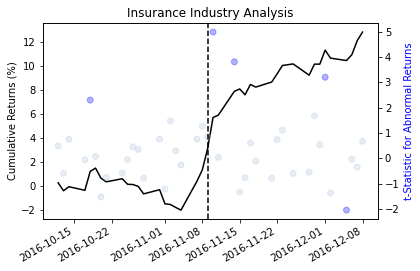

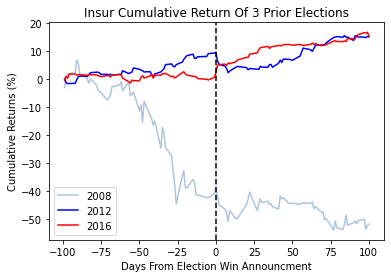

In [64]:
#days_weeks(trump_win,'Drugs')
days_weeks(trump_win,'Insur')
comparison('Insur',-100,100, 'lower left')

The insurance industry also reacted heavily to Trump's victory. Repealing Obamacare was one of Trump's large talking points, whereas his counterpart, Hilary Clinton, was in support of keeping and expanding Obamacare. She wanted to expand the affordable care act, remove copays, and reduce the cost of prescription drugs among many other improvements that would cut into the cash flows of insurance companies (The Office of Hillary Rodham Clinton, N/A). As a result insurance companies would likely suffer tremendously as many would stop buying private insurance and instead opt for the cheaper government-offered option.

So, when Trump was elected, insurance companies breathed a collective sigh of relief, as they could likely keep a similar business model and plan as before. Because Clinton was the massive favorite for the majority of 2016 it was likely that investors were probably selling their shares in healthcare stocks and as a result of Trump's win investors must have seen this as indication that the stock would return to it's former highs. 

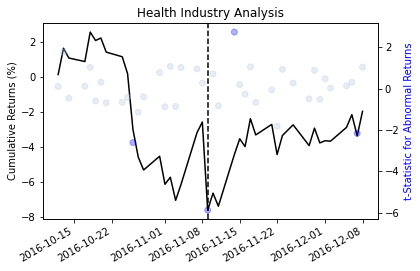

In [18]:
days_weeks(trump_win,'Hlth')

We expected that the healthcare industry would be similar to that of the drugs and insurance industry, but it clearly was not as the day post election saw a large negative return. Upon further research, healthcare industry stocks heavily relies on the cashflows of treating and curing people. So it was less of a surprise that electing a president with plans to replace Obamacare would eat into the cash and profits of hospitals and healthcare institutions. Investors likely responded to Trump's win as sign of future losses for the healthcare industry. 

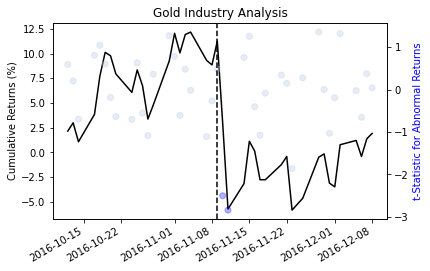

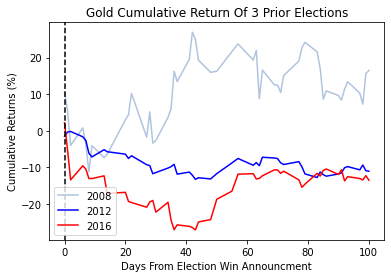

In [14]:
days_weeks(trump_win,'Gold')
comparison('Gold',0,100, 'lower left')

Another interesting find is that gold, a fear index, went down significantly after Trump's election win. Normally, these fear indices are negatively correlated with that stock market. Looks like investors were not panicking on the day, but were more optimistic of future returns. It is interesting to note that gold prices skyrocketed in the months following Obama's election due to the financial crisis. People were seriously panicing back then as evidenced by a 20% increase in it's price. 

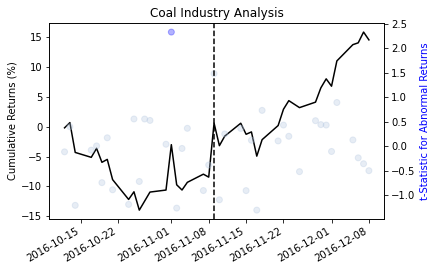

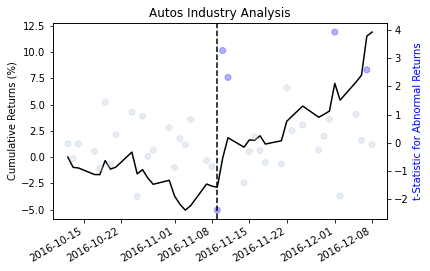

In [19]:
days_weeks(trump_win, 'Coal')
days_weeks(trump_win, 'Autos')

We were curious on how the coal industry was influenced, since Trump made many favorable promises to the coal industry. However, before explaining the data, it is important to note that according to the t-statistic, the gains after the election were not out of the ordinary, so the increase may not have been because of election news. 

As we can see from this graph, after the election result announcement coal experiences a generally positive trending return in the few months following the election within the year 2016. An explanation to this increase is that one key tenant of Trump's campaign was a promise to states with a strong mining history such as Pennsylvania that he would work on implementing policies to get working class Americans in the mining industry back on their feet (Natter & Wade, 2020). As a result of these promises coal saw an uptick in overall returns post the election win.

We also looked at the auto industry along with coal. Climate change remained a heavy topic during this election cycle, so it makes sense that electing a candidate more prone to decreasing environmental protection policies would increase auto stocks significantly. We looked at these two industries alongside each other in order to see the effect of Trump's views and statements toward decreasing environmental regulations.

## How did the market react in the years after the election?

The impact of the 2016 election result clearly impacted the market and individual industries in a number of ways, however the effects did not necessarily stay the same for these industries in the years following the election win.

The industries we identified that had the largest increases during the 1-year period following Trump's election  were the following:

In [17]:
fi.loc[trump_win:'2017-12-31'].apply(cumret).iloc[-1].sort_values().tail()

Fin      0.493409
Mach     0.563849
Aero     0.589600
FabPr    0.590326
Cnstr    0.635458
Name: 2017-12-29 00:00:00, dtype: float64

As shown above, these were the 5 industries that experienced the largest increases following Trump's election. Our analysis will take a look at a few of these, among other industries, below. The rationale for our analysis includes looking at industries during 2017, as well as  beyond into 2018 in order to pinpoint the effect of certain policies that were made during that period into his presidency.  

In [47]:
def cumu_ret(industry, start, end, date):
    cumu = df[[industry]].loc[start:end]
    cumu['Cumulative'] = cumu[industry].add(1).cumprod()*100
    plt.plot(cumu['Cumulative'], color = 'r')
    plt.axvline(datetime.strptime(date, "%Y-%m-%d"), color = 'black', ls = '--')
    plt.title(industry + ' Cumulative Return from ' + start + ' to ' + end)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns (%)')
    plt.xticks(rotation=45)
    plt.show()

In [36]:
def months_years(win_date, industry):
    evt_pm = 252
    est_N = 252*3
    evt_dt = pd.to_datetime(win_date)
    evt_i = df.index.get_loc((evt_dt))
    est_l = evt_i - evt_pm - est_N
    est_r = evt_i - evt_pm
    evt_l = evt_i - evt_pm
    evt_r = evt_i + evt_pm + 1
    res = smf.ols(formula = industry + ' ~ Mkt', data = df.iloc[est_l:est_r]).fit()
    df['RET_hat'] = res.predict(df.iloc[evt_l:evt_r]) # expected return based on CAPM and actual market returns
    df['AR'] = df[industry] - df['RET_hat'] # abnormal or unexpected return
    df['AR_t'] = df['AR'] / np.sqrt(res.scale) # t-stat on abnormal or unexpected return
    cumu_df = fi[[industry]].iloc[evt_l:evt_r].apply(cumret).join(df['AR_t']).dropna()
    x = cumu_df.index
    y1 = cumu_df[industry] * 100
    y2 = cumu_df['AR_t']
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax2.scatter(x,y2, color = np.where(np.abs(y2) > 1.96, 'blue', 'lightsteelblue'), alpha = 0.3)
    ax1.plot(x,y1, color = 'black')
    ax1.set_ylabel('Cumulative Returns (%)', color = 'black')
    ax2.set_ylabel('t-Statistic for Abnormal Returns', color = 'blue')
    plt.axvline(evt_dt, color = 'black', ls = '--')
    fig.autofmt_xdate()
    ax1.set_title(labels[industry] + ' Industry Analysis')
    plt.show()

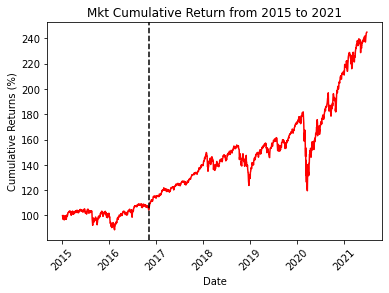

In [37]:
cumu_ret('Mkt','2015','2021',trump_win)

From the above figure we can see that the market has experienced a cumulative return that has more than doubled since he was elected. In order to better understand the way in which the market reacted we will be looking at some of the industries that we identified above as having the largest increases, as well as a few industries that may have reacted negatively to certain policies that Trump implemented.

The first two industries that we'll be looking at include banking and finance, which are both industries that fall within the business sector. In this case we decided to look at these industries in relation to the event study for the date that the Tax Cuts and Jobs Act was finalized in 2017. 

Given Trump's own background in business it was already somewhat clear during his campaign that if elected he would lend support to the business world. 

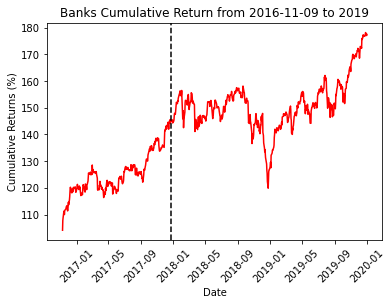

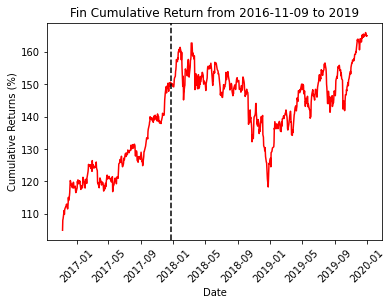

In [65]:
cumu_ret('Banks',trump_win,'2019',corp_tax_cuts)
cumu_ret('Fin',trump_win,'2019',corp_tax_cuts)

December 22nd, 2017 marks a day that caused quite a stir across the U.S. On this day, President Trump signed the Tax Cuts and Jobs Act or TCJA into law. This act resulted in a multitude of tax changes, most notably a standardized single corporate tax rate of 21% from the previous (York & Muresianu, 2020). In the above graphs it can be seen that around a month before the official date that the TCJA is signed into law that there was a relatively drastic jump in the cumulative returns for both the banking and finance industry. This response was likely in reaction to news of the passing of the TCJA that resulted in a jump in returns in response and preparation to this act being officially signed into law.

Though there was a relative jump after this act was passed, the cumulative returns appear less stable after this period and jumped up and down quickly in the months following. It is important to note that near the end of 2018 and into the beginning of 2019 was when the COVID pandemic had begun to hit in other countries around the world. Even though the U.S. did not experience the brunt of the beginning until the beginnings of Spring, other countries were. This did not bode well for business in the U.S. and this trend follows through with the the other industries that are analyzed below.

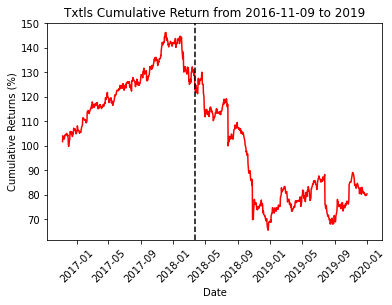

In [48]:
cumu_ret('Txtls',trump_win,'2019',china_goods_tariff)

On March 22nd, 2018 the Trump administration imposed tariffs on as much as $60 billion worth of Chinese goods. These goods included a variety of items from shoes to clothing (Landler & Tankersley, 2018). These actions mark one of Trump's strongest actions in terms of trade against another country. 

The long-term effect of these tariffs can be seen in the cumulative return line graphed in the plot below. The graph shows the long-term significance of enacting the tariffs. The textile industry is shown to largely experience downard trending returns as a result of the tariff, showing the negative impact on the industry as a whole. 

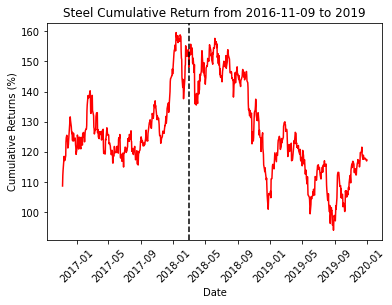

In [42]:
cumu_ret('Steel',trump_win,'2019',steel_tariff)

Only a few weeks before the tariffs imposed on Chinese goods, there were a series of tariffs implemented as well on steel and aluminum. Imposing these tariffs were a promise made on the campaign trail by Trump and impacted the market as he made good on his promise to impose trade tariffs (Swanson, 2018). These tariffs woud impact a multitude of trade partners, such as Canada, South Korea and a number of other countries. The steel industry unsure at how to react at the impending fight with other countries on the matter of global trade reacted. 

For a long time Trump has expressed disapproval of U.S. reliance on other countries for imports and sought to re-start these industries within the U.S. As uncertainty rose, the implementation of these tariffs ultimately caused the steel industry to return with statisticaly significant negative t-stat values. 

Over a longer period the steel industry experiences some ups and downs in terms of cumulative returns. It is likely that in response to the decision to implement these new tariffs that worried U.S. buyers in need of steel for production rushed to order steel before the effect of the tariffs were fully realized thereby leading to price increases. Though the tariffs may show some positive effect in the periods between April 2018 and June 2018, the effect afterwards is largely negative as the industry begins to suffer as a result of the tariffs. 

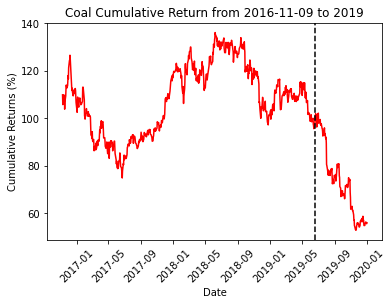

In [50]:
cumu_ret('Coal',trump_win,'2019',ACE_rule_implementation)

One major message of Trump's campaign was the promotion of returning industrial and manufacturing jobs to America. As a result of these promises he sought to repeal the Clean Power plan, which generally aimed reduce carbon dioxide emissions by 2030 relative to 2005 emissions. In place he promoted the implementation of the Affordable Clean Energy rule, which aimed to promote the usage of coal-fired plants once again. As a result of the implementation it only appears to result in one statistically significant value, however in the long-term it can be seen that the implementation of this rule did not help coal. This analysis will continue below. 

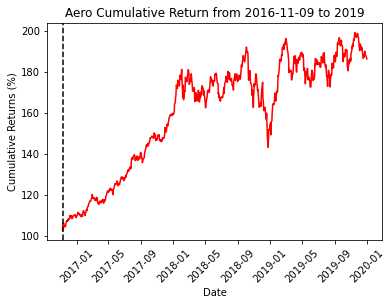

In [51]:
cumu_ret('Aero',trump_win,'2019', trump_win)

Heading into the 2016 election, Trump had previously expressed support for improving infrastructure, which included support for the aviation sector. Likely as a result of this this sector expected positive support from the trump administration (Mosner, 2017).

Trump's impact on the aviation sector seems apparent with the cumulative return of the industry experiencing a gradual increase through to the end of the 2017 period after his election. The positive outlook of the administration towards the aerospace industry likely will promote positive growth for this industry further.

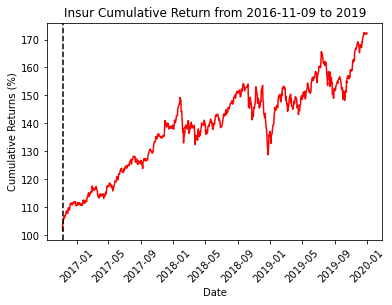

In [61]:
cumu_ret('Insur',trump_win,'2019', trump_win)

Our initial look at the insurance industry during the days and weeks was that the industry was experiencing positive returns. According to the above graph it appears the the industry continues to experience a positive increase in returns generally overtime in the few years after.

Though House Republicans were looking to replace Obamacare with the American Healthcare Act (ACA), the bill was ultimately withdrawn on March 24th, 2017 when it appeared that the bill would not be able to garner enough votes to pass. However, by not enabling Obamacare and dedicating funding towards the program, we believe that major insurance companies continued to grow as a result of this.

To close off our analysis we chose to look at the rolling sharpe ratios for the industries analyzed above.

In [59]:
def sharpe_ratio(r, ppy=252):
    return np.sqrt(ppy) * r.mean() / r.std()

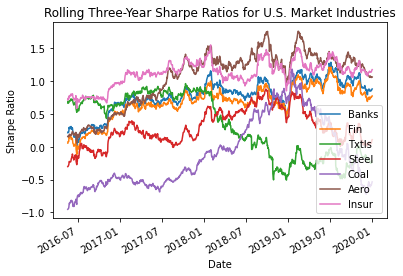

In [66]:
cols = ['Banks', 'Fin', 'Txtls', 'Steel', 'Coal', 'Aero', 'Insur']
sharpe2 = fi.loc['2014':'2019', cols].rolling('1095D', min_periods=600).apply(sharpe_ratio)
sharpe2.plot()
plt.ylabel('Sharpe Ratio')
plt.title('Rolling Three-Year Sharpe Ratios for U.S. Market Industries')
plt.show()

Generally speaking, a sharpe ratio above 1 can be described as a good sharpe ratio relative to the market. When looking at the above graph it can be seen that only the finance, banking, aerospace and insurance industries experienced sharpe ratios above 1 during the shown period of Trump's presidency. This appears to follow our analysis above with Trump's policies supporting the growth of these industries. 

On the other hand it can be seen that textiles and steel experience what would generally be considered sub-optimal sharpe ratios. The ratios for these industries do not break the 1 mark. Steel experiences a general increase between 2016 and 2018, but decreases by a similar amount as a result of tariffs implemented. Textiles as well experiences a rather rapid decrease as a result of tariffs implemented during the year 2018. 

Coal begins at a sharpe ratio of about -1, likely as a result of previous policies promoting sustainable energy and previously increasing restrictions on coal toxins and plant usage. As a result of Trump's support for increasing coal usage it does appear that coal experiences an increase over time, however the effectiveness of Trump's rollback of previous coal restrictions is not actually there. Restrictions such as replacing the Clean Power Plan with a much weaker set of regulations - the Affordable Clean Energy rule. 

One thing to note is that the risk free rate at the time of our analysis is close to 0 and hence we excluded it as a factor in our analysis.

## Conclusion

In conclusion, the election of Trump as President created an effect that was felt across a multitude of industries. In accordance with policies made throughout his time as president, different industries felt effects in different ways.

In the first section we took a look at how the market reacted to the election in industries that Trump mentioned a lot on the campain trail. Our analysis initially looked at the the days and weeks surrounding the election. Banking, finance, insurance, coal and the auto industry all reacted positively in the days following the election. For example, both banking and finance grew between 13 to 14%, insurance grew around 8% and the coal and auto industries grew 15 and 10% respectively.  On the other hand, one industry that shocked us during our analysis was health, which saw a significant decrease in the industry's value, with a decrease of around 5.5%. Gold reacted negatively as well, however it is important to consider the position of Gold as an area investors turn to when the typical market reacts negatively as a way to hedge against those decreasing returns. Gold decreasing seems to suggest ultimately that initially around the election sentiments were generally positive around the market.


In the second section we looked at how the market reacted post-election to both the election in the year or years following, as well as reaction to post-election policies that were implemented by the Trump administration. We took a look at a few industries that recorded high returns immediately after the election such as the finance, banking, aero and insurance industries. These industries continued to display relatively positive returns. We then also looked at textiles and steel in order to see the response to tariffs that were imposed after Trump was appointed. These two industries reacted more negatively. The last two we looked at were coal and aero, which were both industries expected to experience positive growth as a result of Trump's support for these industries. In spite of this coal experienced a general decline, though the aero industry did grow. 

One important thing to note with our analysis is that correlation is not causation. Though there were statistically significant values with all the industries we looked at that does not necessarily mean that it was solely due to the policies that were implemented that caused either an increase or decrease. These trends may have happened in spite of the policies rather than simply because of them.

Ultimately there is a clear effect on the market as a result of Trump's election in 2016. Each industry comprising the market felt some sort of effect though we chose to focus on those that experienced some of the larger effects as a result. Markets will always adjust to new information and change in order to reflect this information. One thing is clear, elections will always continue to affect the market and each coming election will come with policies that will impact industries differently.

## Bibliography

Landler, M., &amp; Tankersley, J. (2018, March 22). Trump hits China with stiff trade measures. The New York Times. https://www.nytimes.com/2018/03/22/us/politics/trump-will-hit-china-with-trade-measures-as-white-house-exempts-allies-from-tariffs.html. 

Mosner, A. M. (2017, January 6). Aviation reform under the Trump administration: What to expect: Insights. Holland &amp; Knight. https://www.hklaw.com/en/insights/publications/2017/01/aviation-reform-under-the-trump-administration-wha. 

Natter, A., &amp; Wade, W. (2020, September 3). Trump Made a Promise to Save Coal in 2016. He Couldn’t Keep It. Bloomberg.com. https://www.bloomberg.com/news/features/2020-09-03/trump-s-broken-coal-promises-could-cost-him-2020-election-support. 

Swanson, A. (2018, March 1). Trump to impose sweeping steel and aluminum tariffs. The New York Times. https://www.nytimes.com/2018/03/01/business/trump-tariffs.html. 

The Office of Hillary Rodham Clinton. (n.d.). Health care. The Office of Hillary Rodham Clinton. https://www.hillaryclinton.com/issues/health-care/. 

York, E., &amp; Muresianu, A. (2020, July 30). TCJA simplified tax filing process for millions of households. Tax Foundation. https://taxfoundation.org/the-tax-cuts-and-jobs-act-simplified-the-tax-filing-process-for-millions-of-americans/. 